#  Прогнозирование заказов такси

**Цель:** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

**Целевой показатель:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## 1. Загрузка данных

В ячейке ниже будут подгружаться необходимые библиотеки и инструменты для работы над проектом.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

Создадим переменную для датафрейма. Сразу же укажем в качестве индекса первую колонку, которая будет конвертирована в дату.

In [2]:
try:
    data = pd.read_csv('/Users/maksimkuznetsov/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим, какие срезы дат в датафрейме.

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Видим, что у нас данные агрегированы по десятиминуткам. Теперь посмотрим информацию о датафрейме.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## 2. Анализ данных

Мы помним, что данные начинаются с 1 марта 2018, теперь посмотрим, когда они заканчиваются.

In [5]:
data.last_valid_index()

Timestamp('2018-08-31 23:50:00')

Итак, датафрейм с 01.03.2018 - 31.08.2018.

Проверим данные на монотонность.

In [6]:
data.index.is_monotonic

True

С монотонностью все ок.
<br>
Посмотрим на графическое представление данных.

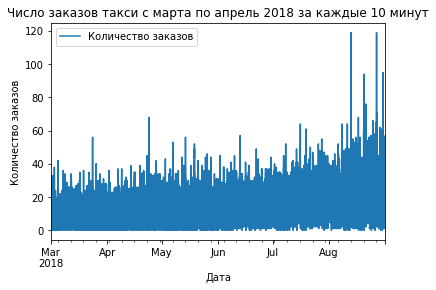

In [7]:
data.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Число заказов такси с марта по апрель 2018 за каждые 10 минут')
plt.legend(['Количество заказов'])
plt.show()

Видим, что график малоинформативный, очень много колебаний. Неудивительно, ведь у нас данные нересемплированы. Сейчас можно сделать вывод, что мы имем дело с нестационарным процессом, так как на графике заметно увеличение среднего. А возможно, это изменение коридоров для стандартного отклонения. В дальнейшем при рассмотрении ситуации по сезонам, когда разделим данные на дни, мы сможем выделить какие-то особенности, а пока посмотрим на гистограмму данных.

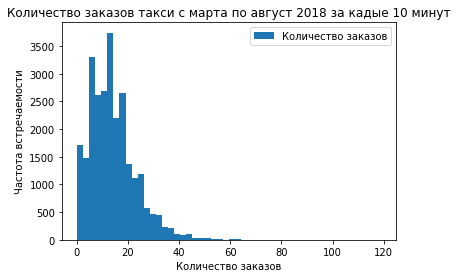

In [8]:
data.plot(kind='hist', bins=50)
plt.xlabel('Количество заказов')
plt.ylabel('Частота встречаемости')
plt.title('Количество заказов такси с марта по август 2018 за кадые 10 минут')
plt.legend(['Количество заказов'])
plt.show()

Видим, что распределение достаточно адекватное, близко к нормальному. Существует тянующийся хвост в область большого количества заказов. На мой взгляд, это нормально, бывает же, когда час-пик.

In [9]:
data[data['num_orders'] > 40].head(20)

,num_orders
datetime,
2018-03-05 01:00:00,42
2018-03-24 00:50:00,56
2018-04-23 00:50:00,45
2018-04-24 00:10:00,49
2018-04-24 00:20:00,58
2018-04-24 00:30:00,68
2018-04-28 00:30:00,42
2018-05-03 00:40:00,43
2018-05-03 00:50:00,42


На самом деле, я оказался неправ, видим, что бОльшее число заказов характерно для позднего вечера и ночи, когда перестает работать общественный транспорт. Теперь оценим, есть ли часы с нулевыми заказами.

In [10]:
data[data['num_orders'] == 0]

,num_orders
datetime,
2018-03-01 05:20:00,0
2018-03-01 05:40:00,0
2018-03-01 05:50:00,0
2018-03-01 06:00:00,0
2018-03-01 06:10:00,0
...,...
2018-08-24 05:50:00,0
2018-08-26 05:40:00,0
2018-08-29 07:00:00,0


Есть много строк с нулевым количеством заказов. Это вполне вероятно, так как время - раннее утро.

### 2.1. Тренды/сезонность. Ресемплирование по дням

Теперь посмотрим на тренды и сезонность. Для этого сначала ресемплируем данные по одному дню.

In [11]:
data_daily = data.resample('1D').sum()
data_daily.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


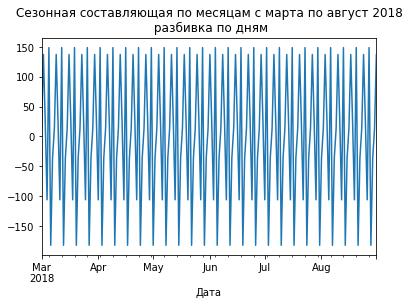

In [12]:
seasonal_decompose(data_daily['num_orders']).seasonal.plot()
plt.xlabel('Дата')
plt.title('Cезонная составляющая по месяцам с марта по август 2018\n разбивка по дням')
plt.show()

Видим, что информация по сезонности внутри одного месяца является малополезной. Внутри месяца есть высокие и низкие сезоны. Теперь глянем на тренд.

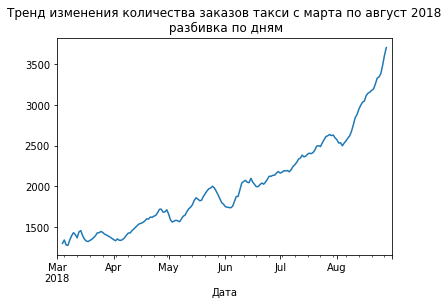

In [13]:
seasonal_decompose(data_daily['num_orders']).trend.plot()
plt.xlabel('Дата')
plt.title('Тренд изменения количества заказов такси с марта по август 2018\n разбивка по дням')
plt.show()

Здесь мы видим, что количество поездок увеличивается от начала года к концу лета. Интересная ситуация, не знаю, как это можно интерпретировать, но статистический факт - штука железная.

Теперь посмотрим, как зависит количество заказов от дня недели.

In [15]:
data_daily['dayofweek'] = data_daily.index.dayofweek
data_daily.head()

,num_orders,dayofweek
datetime,,
2018-03-01,1364,3
2018-03-02,1506,4
2018-03-03,1290,5
2018-03-04,1141,6
2018-03-05,1259,0


Построим график распределения заказов для Апреля 2018.

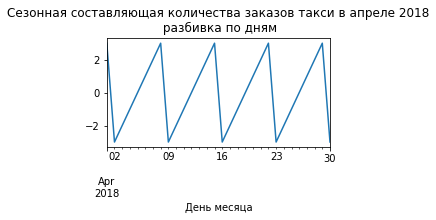

In [16]:
data_march = data_daily['2018-04':'2018-04']
seasonal_decompose(data_march['dayofweek']).seasonal.plot(figsize=(4,2))
plt.xlabel('День месяца')
plt.title('Сезонная составляющая количества заказов такси в апреле 2018\n разбивка по дням')
plt.show()

Очевидно, что к концу недели число заказов увеличивается, так как 2 апреля 2018 года - это понедельник.



### 2.2. Тренды/сезонность. Ресемплирование по часам

Теперь посмотрим на распределение заказов в течение дня с разбивкой по часам.

In [17]:
data_hour = data.resample('1H').sum()
data_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


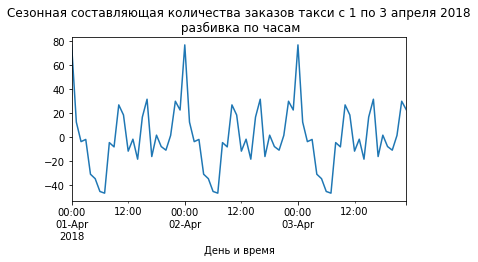

In [18]:
data_hour_slice = data_hour['2018-04-01':'2018-04-03'] # берем срез на начала апреля - это сб, вск и пн.
seasonal_decompose(data_hour_slice['num_orders']).seasonal.plot(figsize=(6,3)) # смотрим на сезонность
plt.xlabel('День и время')
plt.title('Сезонная составляющая количества заказов такси с 1 по 3 апреля 2018\n разбивка по часам')
plt.show()

Здесь видим, что максимальное количество заказов наблюдается около полуночи. Есть всплески ближе к обеденному времени и времени ухода с работы. Все логично.

**Вывод по этапу анализа данных:**
<br>
Анализ данных показал, что существует уввеличение заказов:
- к осени;
- к концу недели; 
- к концу суток.

## 3. Обучение моделей


Пока наша таблица с ресемплированием данных по часам не является полезной для машинного обучения. Нужно создать дополнительные признаки. Это будут год, месяц, день, день недели, скользящее среднее и отстающие значения (лаг). Сделаем для этого функцию. При этом сделаем так, чтобы можно было менять в функции выше указанные параметры.

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Создадим признаки, ипользуя функцию. Пускай будет 24 лага, сколько в сутках часов.

In [20]:
make_features(data_hour, 24, 6)

In [21]:
data_hour.head()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим, с какими параметрами количество заказов больше всего коррелирует.

In [22]:
pd.set_option('display.max_columns', None)
data_hour.corr().round(2).head(1)

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
num_orders,1.0,0.0,0.17,-0.02,0.62,0.47,0.32,0.25,0.23,0.24,0.29,0.31,0.27,0.26,0.32,0.33,0.31,0.26,0.24,0.27,0.26,0.21,0.2,0.22,0.27,0.41,0.56,0.69,0.48


Итак есть средняя корреляция (0.5 - 0.7) с месяцем, лагами 1, 23 и 24 ч. 

Разделим выборку на обучающую и тестовую. Не забудем сделать так, чтобы она не перемешивалась, так как важно, чтобы тест был на более поздних данных. Так как мы сделали отстающие значения, то в первых 24 ячейках будут данные формата None. Их нужно будет исключить из обучающей выборки. Создадим в выборках обычные признаки и целевой.

In [63]:
train, test = train_test_split(data_hour, test_size=0.1, shuffle=False)

train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

In [65]:
print(features_train.shape, target_train.shape)
print()
print(features_test.shape, target_test.shape)

(3950, 28) (3950,)

(442, 28) (442,)


Согласно заданию, при обучении мне нужно использовать несколько моделей. Поэтому я буду применять **RandomForestRegressor**, **LinearRegression** и модель градиентного бустинга - **LightGBM**.

Для подбора лучших гиперпараметров разных моделей используем **GridSearch**. Вызовем **TimeSeriesSplit**, чтобы при кросс-валидации тестовые индексы были больше трейновых. Метрикой уже будет RMSE. Кстати, создадим для ее вычисления функцию.

In [72]:
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    return mse**0.5

rmse_score = make_scorer(rmse, greater_is_better = False)

**RandomForestRegressor**

In [75]:
forest = RandomForestRegressor(random_state=12345)
    
parameters_forest = {'n_estimators': range(80, 120, 10), 'max_depth': range(10, 20)}

tscv = TimeSeriesSplit(n_splits=5)
    
grid_search_forest = GridSearchCV(estimator=forest, param_grid=parameters_forest, scoring=rmse_score, 
                                  cv=tscv, n_jobs=-1)
    
grid_search_forest.fit(features_train, target_train)

print('Параметры лучшей модели', grid_search_forest.best_estimator_)

print('RMSE для лучшей модели RandomForestRegressor:', (grid_search_forest.best_score_*(-1)).round(2))


Параметры лучшей модели RandomForestRegressor(max_depth=19, n_estimators=110, random_state=12345)
RMSE для лучшей модели RandomForestRegressor: 25.21


**LinearRegression**

In [77]:
linear = LinearRegression()

parameters_linear = {}

tscv = TimeSeriesSplit(n_splits=5)

grid_search_linear = GridSearchCV(estimator=linear, param_grid=parameters_linear, scoring=rmse_score, \
                                            cv=tscv, n_jobs=-1)

grid_search_linear.fit(features_train, target_train)

print('RMSE для лучшей модели LinearRegression:', (grid_search_linear.best_score_*(-1)).round(2))

RMSE для лучшей модели LinearRegression: 27.15


**LGBMRegressor**

In [80]:
lgbm = lgb.LGBMRegressor()

parameters_lgbm = {
    'max_depth': [10, 15, 20, 50],
    'num_leaves': [50, 100, 200, 300]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=parameters_lgbm, scoring=rmse_score, 
                                cv=tscv, n_jobs=-1)

grid_search_lgbm.fit(features_train, target_train)

print('Параметры лучшей модели', grid_search_lgbm.best_estimator_)

print('RMSE для лучшей модели LightGBM:', (grid_search_lgbm.best_score_*(-1)).round(2))

Параметры лучшей модели LGBMRegressor(max_depth=15, num_leaves=200)
RMSE для лучшей модели LightGBM: 25.06


**Вывод** по анализу обучения моделей:
<br>
<br>
Модель градиентного бустинга LGBM показала себя лучше всех остальных, ее RMSE=25.06. Хотя и RandomForestRegressor отстает на немного.

## 4. Тестирование лучшей модели

Протестируем модель LightGBM, используя тестовую выборку.

In [85]:
predictions_best = grid_search_lgbm.best_estimator_.predict(features_test)

print('RMSE для лучшей модели LightGBM:', (mean_squared_error(target_test, predictions_best)**0.5).round(2))

RMSE для лучшей модели LightGBM: 41.27


RMSE вполне хорошее, меньше запрошенных 48.

## 5. Вывод по проекту

Основной задачей проекта являлось построение модели для компании "Четенькое такси", которая способна качественно предсказывать количество заказов клиентов такси на следующий час.

Анализ данных показал, что наибольшее число заказов характерно для следующих временных отрезков:
- конец лето и осень
- конец недели (выходные)
- конец суток, самое начало новых суток.

Наилучшим образом в машинном обучении показала себя моедель градиентного бустинга. Ее RMSE = 41.27, что намного меньше изначально запрошенного 48.
